In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import sacc, sys
sys.path.append('/home/diegop/Desktop/ACT/code_release/')
import act_dr6_analysis.mle as mk
import act_dr6_analysis.binning as bf
from act_dr6_analysis import sacc_dir, lcdm_dir            

Working from /home/diegop/Desktop/ACT/code_release/act_dr6_analysis


# Run baseline results
Fitting birefringence ($\beta$) and miscalibration angles ($\alpha_i$) to the $C_\ell^{EB}$ and $C_\ell^{TB}$ spectra of ACT DR6. We use a prior on the instrument optical model that assumes a 90% correlation between the $\alpha_i$ housed in the same PA. We include PA4 f220 and use the baseline mutipole cut.

In [2]:
print('-------------------------------------------------------------------')
print("Fitting alpha_i + beta (EB & TB) with the '90% correlation within PA' prior :\n")

bands          = ['pa4_f220', 'pa5_f090', 'pa5_f150', 'pa6_f090', 'pa6_f150']
bp             = bf.BandPowers('baseline')
exclude_auto   = False
offdiag_blocks = True
ell_diagonal   = False


mle = mk.MLE(bands, 'ab', 'EBxTB', bp, 
             alpha_prior_file='diag0.09-0.09-0.11_PA90_pa456',
             exclude_auto_spectra=False, include_off_diagonal_obs_blocks=True, ell_diagonal=False)
mle.load_data()
res = mle.solve(save=False)
mk.summary(res, show_chi2=False, alpha_pa5_discrepancy=False)

-------------------------------------------------------------------
Fitting alpha_i + beta (EB & TB) with the '90% correlation within PA' prior :

Solving linear system ...
	 iter 1:
[ 12.693 arcmin, 1.365 arcmin, -0.750 arcmin, 1.544 arcmin, -2.125 arcmin, -1.569 arcmin ]
	 iter 2:
[ 12.692 arcmin, 1.363 arcmin, -0.750 arcmin, 1.544 arcmin, -2.123 arcmin, -1.567 arcmin ]
Done!
beta = (0.212 \pm 0.072)deg
alpha pa4_f220 = (0.023 \pm 0.085)deg
alpha pa5_f090 = (-0.012 \pm 0.072)deg
alpha pa5_f150 = (0.026 \pm 0.071)deg
alpha pa6_f090 = (-0.035 \pm 0.077)deg
alpha pa6_f150 = (-0.026 \pm 0.076)deg


# Calculate stacked $EB$ and $TB$ spectra
We calculate the inverse-variance weighted average across frequencies from 
\begin{equation}
\mathrm{E}[D_b^{XY}] = \frac{\sum_{ijpq}(\mathbf{C}^{ijpq}_{XY,b})^{-1}D_{b}^{X_pY_q,\mathrm{o}}}{\sum_{ijpq}(\mathbf{C}^{ijpq}_{XY,b})^{-1}}
\end{equation}
with variance 
\begin{equation}
\mathrm{Var}[D_b^{XY}] = \frac{1}{\sum_{ijpq}(\mathbf{C}^{ijpq}_{XY,b})^{-1}},
\end{equation}
where $\mathbf{C}^{ijpq}_{XY,b}=\mathrm{Cov}(D_b^{X_iY_j,\mathrm{o}},D_{b}^{X_pY_q,\mathrm{o}})$.

In [3]:
# Load DR6 data
sacc_file = sacc.Sacc.load_fits(f"{sacc_dir}/v1.0/dr6_data.fits")
full_vec  = sacc_file.mean
full_cov  = sacc_file.covariance.covmat

# In the baseline multipole cut, different lmin are adopted for each array-band
# Hence, we need to know which lmin is available for every ixj combination of array-bands
# For any given ixj combination, we will take the most restrictive (i.e., higher) lmin
b_dict = {}
for b in bp.g_b:
    b_dict[b] = {'(ii,jj)':[]}
    
for (ii, jj) in mle.IJidx:
    fi, fj = bands[ii], bands[jj]
    b_ij   = np.sort(list(set(bp.conf[fi]['b']).intersection(set(bp.conf[fj]['b']))))
    for b in bp.g_b:
        if b in b_ij:
            b_dict[b]['(ii,jj)'].append((ii,jj))

# Bins included in the stack
stack_ell = []
for b in bp.g_b:
    b_dict[b]['Nspecs'] = len(b_dict[b]['(ii,jj)'])
    if b_dict[b]['Nspecs'] != 0:
        stack_ell.append(b)   
stack_ell = np.array(stack_ell)

# Calculate stacked spectra and their variance
stack_vec_EB = np.zeros(len(stack_ell), dtype=np.float64)
stack_var_EB = np.zeros(len(stack_ell), dtype=np.float64)
stack_vec_TB = np.zeros(len(stack_ell), dtype=np.float64)
stack_var_TB = np.zeros(len(stack_ell), dtype=np.float64)

for ll, b in enumerate(stack_ell):
    Nspec     = b_dict[b]['Nspecs']
    sel       = bp.g_b==b
    u         = np.ones(Nspec)
    
    vec_EB_ij = np.zeros(Nspec, dtype=np.float64)
    cov_EB_EB = np.zeros((Nspec, Nspec), dtype=np.float64)
    vec_TB_ij = np.zeros(Nspec, dtype=np.float64)
    cov_TB_TB = np.zeros((Nspec, Nspec), dtype=np.float64)
    
    mm = 0
    for (ii, jj) in b_dict[b]['(ii,jj)']:
        # fill the vector
        s_eb_ij, e_eb_ij = bf.indices('E', bands[ii], 'B', bands[jj])
        idx_eb_mm        = np.arange(s_eb_ij, e_eb_ij)
        vec_EB_ij[mm]    = full_vec[s_eb_ij:e_eb_ij][sel][0]
        
        s_tb_ij, e_tb_ij = bf.indices('T', bands[ii], 'B', bands[jj])
        idx_tb_mm        = np.arange(s_tb_ij, e_tb_ij)
        vec_TB_ij[mm]    = full_vec[s_tb_ij:e_tb_ij][sel][0]
        # fill the matrix
        nn = 0
        for (pp, qq) in b_dict[b]['(ii,jj)']:
            s_eb_pq, e_eb_pq  = bf.indices('E', bands[pp], 'B', bands[qq])
            idx_eb_nn         = np.arange(s_eb_pq, e_eb_pq)
            cov_EB_EB[mm, nn] = np.diag(full_cov[np.ix_(idx_eb_mm, idx_eb_nn)])[sel][0]
            
            s_tb_pq, e_tb_pq  = bf.indices('T', bands[pp], 'B', bands[qq])
            idx_tb_nn         = np.arange(s_tb_pq, e_tb_pq)
            cov_TB_TB[mm, nn] = np.diag(full_cov[np.ix_(idx_tb_mm, idx_tb_nn)])[sel][0]
            nn += 1
        mm += 1
    
    # for each bin, combination of spectra that minimizes the variance across array-bands
    iC_EB              = np.linalg.inv(cov_EB_EB)
    b_dict[b]['iC EB'] = iC_EB
    stack_var_EB[ll]   = 1/np.matmul(u, np.matmul(iC_EB, u))
    stack_vec_EB[ll]   = np.matmul(u, np.matmul(iC_EB, vec_EB_ij))*stack_var_EB[ll] 
    
    iC_TB              = np.linalg.inv(cov_TB_TB)
    b_dict[b]['iC TB'] = iC_TB
    stack_var_TB[ll]   = 1/np.matmul(u, np.matmul(iC_TB, u))
    stack_vec_TB[ll]   = np.matmul(u, np.matmul(iC_TB, vec_TB_ij))*stack_var_TB[ll] 


# Calculate $1\,\sigma$ confidence contours

Our estimator uses an iterative semi-analytical formalism to find the values of $\alpha_i$ and $\beta$ that maximize the posterior distribution. The uncertainty associated with the maximum posterior values is calculated through the Fisher matrix approximation. Hence, to calculate confidence contours, we first need to generate random samples from such a Gaussian posterior.

In [4]:
# Generate random samples from the Gaussian posterior
Nsim = 20000
L    = np.linalg.cholesky(res['covariance/rad^2'][-1])
rdn  = np.matmul(L, np.random.normal(loc=0, scale=1, size=(mle.Nvar, Nsim)))
rdn  = np.moveaxis(rdn, 0, 1)
rdn += res['angs/rad'][-1]

# Get reference power spectra    
lcdm_file = np.loadtxt(f'{lcdm_dir}/dr6_lcdm_best_fits/cmb.dat', skiprows=1)
# Parameters are ordered like: l Dl_TT Dl_TE Dl_TB Dl_ET Dl_BT Dl_EE Dl_EB Dl_BE Dl_BB
full_ell, EEc_l, BBc_l, TEc_l = lcdm_file[:, 0], lcdm_file[:, 6], lcdm_file[:, 9], lcdm_file[:, 2]
# Bin the spectra and select the bins to keep
TEc_b_all = bf.bin_cls(np.concatenate(([0.0, 0.0], TEc_l)), bp.g_info)
EEc_b_all = bf.bin_cls(np.concatenate(([0.0, 0.0], EEc_l)), bp.g_info)
BBc_b_all = bf.bin_cls(np.concatenate(([0.0, 0.0], BBc_l)), bp.g_info)
TEc_b, EEc_b, BBc_b = [], [], []
for ii, b in enumerate(bp.g_b):
    if b_dict[b]['Nspecs'] != 0:
        TEc_b.append(TEc_b_all[ii])
        EEc_b.append(EEc_b_all[ii])
        BBc_b.append(BBc_b_all[ii])
TEc_b = np.array(TEc_b)
EEc_b = np.array(EEc_b)
BBc_b = np.array(BBc_b)

# Confidence contour for birefringence
# Simple case where ILC is not needed
cl_EB_beta_l = np.zeros((len(full_ell), Nsim), dtype=np.float64)
cl_TB_beta_l = np.zeros((len(full_ell), Nsim), dtype=np.float64)
for ll in range(len(full_ell)):
    cl_EB_beta_l[ll, :] = 0.5*np.sin(4*rdn[:, 0])*(EEc_l[ll]-BBc_l[ll])
    cl_TB_beta_l[ll, :] = np.sin(2*rdn[:, 0])*TEc_l[ll]
# Get mean and std
CL_EB_beta = [cl_EB_beta_l.mean(axis=1), cl_EB_beta_l.std(axis=1)]
CL_TB_beta = [cl_TB_beta_l.mean(axis=1), cl_TB_beta_l.std(axis=1)]


# Confidence contour for miscalibration, and miscalibratin + birefringence
# More complex case where ILC is needed
cl_EB_all_b   = np.zeros((len(stack_ell), Nsim), dtype=np.float64)
cl_TB_all_b   = np.zeros((len(stack_ell), Nsim), dtype=np.float64)
cl_EB_alpha_b = np.zeros((len(stack_ell), Nsim), dtype=np.float64)
cl_TB_alpha_b = np.zeros((len(stack_ell), Nsim), dtype=np.float64)
for ll, b in enumerate(stack_ell):
    Nspec     = b_dict[b]['Nspecs']
    sel       = stack_ell==b
    u         = np.ones(Nspec)
    
    vec_EB_all_ij   = np.zeros((Nspec, Nsim), dtype=np.float64)
    vec_TB_all_ij   = np.zeros((Nspec, Nsim), dtype=np.float64)
    vec_EB_alpha_ij = np.zeros((Nspec, Nsim), dtype=np.float64)
    vec_TB_alpha_ij = np.zeros((Nspec, Nsim), dtype=np.float64)
    mm = 0
    for (ii, jj) in b_dict[b]['(ii,jj)']:
        # fill the vector
        beta = rdn[:, 0]
        ai   = rdn[:, ii+1]
        aj   = rdn[:, jj+1]
        
        vec_EB_all_ij[mm, :]  = np.cos(2*ai+2*beta)*np.sin(2*aj+2*beta)*EEc_b[sel]
        vec_EB_all_ij[mm, :] -= np.sin(2*ai+2*beta)*np.cos(2*aj+2*beta)*BBc_b[sel]
        vec_TB_all_ij[mm, :]  = np.sin(2*aj+2*beta)*TEc_b[sel]  
        
        vec_EB_alpha_ij[mm, :] = 0.5*np.sin(2*ai+2*aj)*(EEc_b[sel]-BBc_b[sel])
        vec_EB_alpha_ij[mm, :] = 0.5*np.sin(2*ai+2*aj)*(EEc_b[sel]-BBc_b[sel])
        vec_TB_alpha_ij[mm, :] = np.sin(2*aj)*TEc_b[sel]

        mm += 1
    
    # load matrices calculated before
    iC_EB                = b_dict[b]['iC EB'] 
    iC_TB                = b_dict[b]['iC TB']

    # for each bin, combination of spectra that minimizes the variance across array-bands
    var_EB               = 1/np.matmul(u, np.matmul(iC_EB, u))
    cl_EB_alpha_b[ll, :] = np.matmul(u, np.matmul(iC_EB, vec_EB_alpha_ij))*var_EB 
    cl_EB_all_b[ll, :]   = np.matmul(u, np.matmul(iC_EB, vec_EB_all_ij))*var_EB
    
    var_TB               = 1/np.matmul(u, np.matmul(iC_TB, u))
    cl_TB_alpha_b[ll, :] = np.matmul(u, np.matmul(iC_TB, vec_TB_alpha_ij))*var_TB 
    cl_TB_all_b[ll, :]   = np.matmul(u, np.matmul(iC_TB, vec_TB_all_ij))*var_TB 

# Get mean and std
CL_EB_all = [cl_EB_all_b.mean(axis=1), cl_EB_all_b.std(axis=1)]
CL_TB_all = [cl_TB_all_b.mean(axis=1), cl_TB_all_b.std(axis=1)]

CL_EB_alpha = [cl_EB_alpha_b.mean(axis=1), cl_EB_alpha_b.std(axis=1)]
CL_TB_alpha = [cl_TB_alpha_b.mean(axis=1), cl_TB_alpha_b.std(axis=1)]

# Stacked $EB$ spectrum

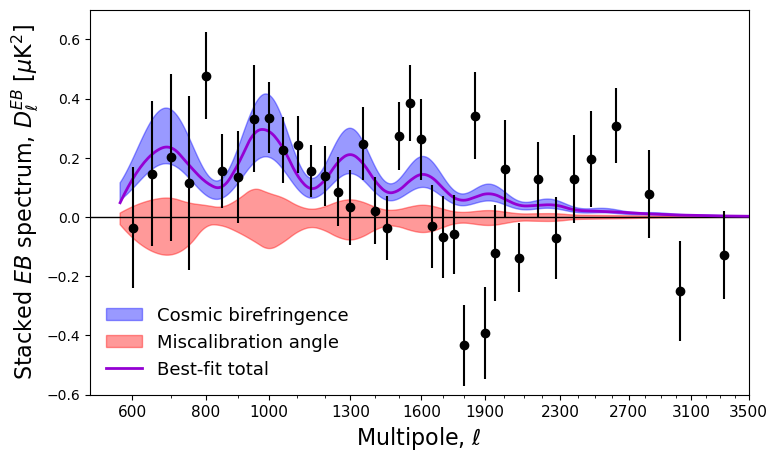

In [5]:
#####################################################################
### Plot config
#####################################################################
xmin         = 570
sel          = full_ell>=xmin
s_exp        = 0.4
xticks_major = np.array([600, 800, 1000, 1300, 1600, 1900, 2300, 2700, 3100, 3500])
xlabel_major = np.copy(xticks_major).astype(str)
xticks_minor = np.arange(600, 3600, 100)
xlabel_minor = np.repeat('', len(xticks_minor))
#####################################################################
### Interpolate functions
#####################################################################
interp_x  = np.sort(np.concatenate((stack_ell, np.arange(xmin, 2500, 5))))
f_a_upper = interp1d(stack_ell, CL_EB_alpha[0] + CL_EB_alpha[1], kind='quadratic', fill_value="extrapolate")
f_a_lower = interp1d(stack_ell, CL_EB_alpha[0] - CL_EB_alpha[1], kind='quadratic', fill_value="extrapolate")
f_all     = interp1d(stack_ell, CL_EB_all[0],                    kind='quadratic', fill_value="extrapolate")
#####################################################################

plt.figure(figsize=(8.5, 5.0))
plt.axhline(0, lw=1, color='k')

plt.fill_between(full_ell[sel], CL_EB_beta[0][sel] - CL_EB_beta[1][sel], 
                 y2=CL_EB_beta[0][sel] + CL_EB_beta[1][sel], 
                 color='blue', alpha=0.4, label=r'Cosmic birefringence')

plt.fill_between(interp_x, f_a_lower(interp_x), y2=f_a_upper(interp_x), 
                  color='red', alpha=0.4, label=r'Miscalibration angle')

plt.plot(interp_x, f_all(interp_x), '-',  color='darkviolet', lw=2, label='Best-fit total')

plt.errorbar(stack_ell, stack_vec_EB, yerr=np.sqrt(stack_var_EB), fmt='o', color='k')

plt.legend(fontsize=13, loc=3, frameon=False)

plt.ylabel(r'Stacked $EB$ spectrum, $D_\ell^{EB}$ [$\mu$K$^2$]', fontsize=16)
plt.ylim((-0.6, 0.7))
plt.yticks(fontsize=10)

plt.xlabel(r'Multipole, $\ell$', fontsize=16)
plt.xscale('function', functions=(lambda x: x**s_exp, lambda x: x**(1/s_exp)))
plt.xlim((500, 3500))
plt.xticks(ticks=xticks_major, labels=xlabel_major, fontsize=11)
plt.xticks(ticks=xticks_minor, labels=xlabel_minor, fontsize=11, minor=True)

plt.show()

# Stacked $TB$ spectrum

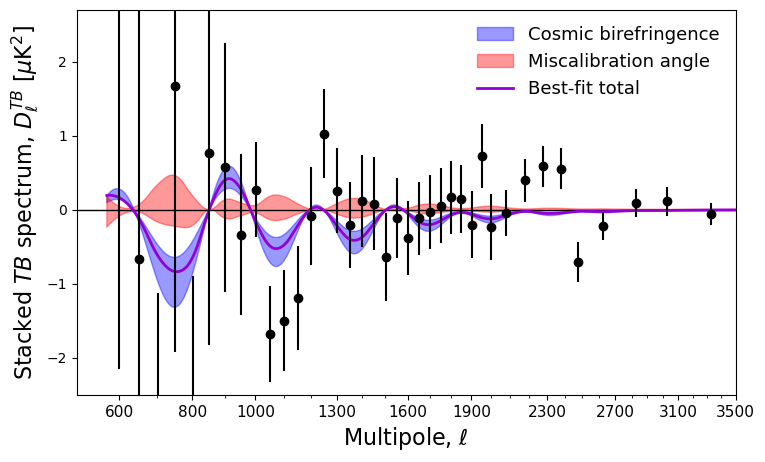

In [6]:
#####################################################################
### Plot config
#####################################################################
xmin         = 570
sel          = full_ell>=xmin
s_exp        = 0.4
xticks_major = np.array([600, 800, 1000, 1300, 1600, 1900, 2300, 2700, 3100, 3500])
xlabel_major = np.copy(xticks_major).astype(str)
xticks_minor = np.arange(600, 3600, 100)
xlabel_minor = np.repeat('', len(xticks_minor))
#####################################################################
### Interpolate functions
#####################################################################
interp_x  = np.sort(np.concatenate((stack_ell, np.arange(xmin, 2500, 5))))
f_a_upper = interp1d(stack_ell, CL_TB_alpha[0] + CL_TB_alpha[1], kind='quadratic', fill_value="extrapolate")
f_a_lower = interp1d(stack_ell, CL_TB_alpha[0] - CL_TB_alpha[1], kind='quadratic', fill_value="extrapolate")
f_all     = interp1d(stack_ell, CL_TB_all[0],                    kind='quadratic', fill_value="extrapolate")
#####################################################################


plt.figure(figsize=(8.5, 5.0))
plt.axhline(0, lw=1, color='k')

plt.fill_between(full_ell[sel], CL_TB_beta[0][sel] - CL_TB_beta[1][sel], 
                 y2=CL_TB_beta[0][sel] + CL_TB_beta[1][sel], 
                 color='blue', alpha=0.4, label=r'Cosmic birefringence')

plt.fill_between(interp_x, f_a_lower(interp_x), y2=f_a_upper(interp_x), 
                  color='red', alpha=0.4, label=r'Miscalibration angle')

plt.plot(interp_x, f_all(interp_x), '-', color='darkviolet', lw=2, label='Best-fit total')

plt.errorbar(stack_ell, stack_vec_TB, yerr=np.sqrt(stack_var_TB), fmt='o', color='k')

plt.legend(fontsize=13, loc=1, frameon=False)

plt.ylabel(r'Stacked $TB$ spectrum, $D_\ell^{TB}$ [$\mu$K$^2$]', fontsize=16)
plt.ylim((-2.5, 2.7))
plt.yticks(fontsize=10)

plt.xlabel(r'Multipole, $\ell$', fontsize=16)
plt.xscale('function', functions=(lambda x: x**s_exp, lambda x: x**(1/s_exp)))
plt.xlim((500, 3500))
plt.xticks(ticks=xticks_major, labels=xlabel_major, fontsize=11)
plt.xticks(ticks=xticks_minor, labels=xlabel_minor, fontsize=11, minor=True)

plt.show()